In [5]:
import json
import os
import shutil
from datetime import datetime, timedelta

import numpy as np
import scipy
import strax as sx
from bson import json_util
from tqdm import tqdm
import lz4.frame as lz4

import helix as hx
from helix import units

import numba
import pandas as pd
import sys
from glob import glob
from matplotlib import pyplot as plt

run_id = 'run10' 
duration = 15  # seconds
raw_data_dir = 'toy_data'  # to save the raw toy data
helix_data_dir = 'test_helix_data'  # to save the run metadata
baseline_step = 0  # add a baseline equal to baseline_step*channel_index to each channel

# methods and classes marked with the @export decorator are added to the __all__ namespace to make them importable via
# the star-notation ('from .module_name import *')
export, __all__ = sx.exporter()

def generate_silent_traces(n_traces, psd, sampling_frequency=1.0):
    """
    Function to generate silent traces (zeros) with the same structure as the noise generator.
    :param n_traces: int. Number of traces to generate.
    :param psd: ndarray. Folded power spectral density (not used, but kept for structure consistency).
    :param sampling_frequency: float. Sample frequency in Hz.
    :returns: ndarray. An array of silent (zero) traces.
    """
    trace_length = hx.psd_to_trace_length(len(psd))
    
    # Generate an array of zeros with the appropriate shape
    silent_traces = np.zeros((n_traces, trace_length))
    
    return silent_traces
@export
def get_pink_psd(trace_length, sampling_dt, noise_std):
    """
    Returns folded PSD corresponding to 1/f pink noise, empirically scaled to make the standard deviation of the noise
    produced from this PSD to be close to the provided noise_std value

    :param trace_length: length of noise traces in samples
    :param sampling_dt: sampling time in ns
    :param noise_std: noise standard deviation
    :return: a tuple of (f, psd), where f is the array of frequencies in Hz, and psd is the array of PSD components
    in A^2/Hz. Can be plotted with plt.loglog(f, psd)
    """
    f = scipy.fft.rfftfreq(trace_length, d=sampling_dt / units.s)
    f[0] = f[1]
    # empirical approximate scaling to match the standard deviation of the resulting noise.
    # This is totally crazy, it's a random expression that scales the PSD in a way that the standard deviation of the
    # noise produced from this PSD somewhat matches the requested noise_std
    # TODO: derive the actual scaling that would properly work and make sense instead of this monster
    scaling = 1 / (1 + (np.log10(trace_length) - 4.5) / 10) ** 2 / 10.3
    psd = scaling*(noise_std**2) / f
    psd[-1] = psd[-1] / 2
    # Could use 0 for the DC component of the PSD, but it messes up the plotting in log scale.
    # The value doesn't matter anyway, we are not generating noise DC components. Using the smallest positive float
    psd[0] = np.nextafter(1, 2)
    f[0] = 0
    return f, psd

def load_traces_from_csv(file_path):
    """
    Reads the CSV file containing traces and returns them as a NumPy array.
    :param file_path: str. Path to the CSV file.
    :returns: ndarray. Array of traces with shape (n_traces, 32768).
    """
    traces_df = pd.read_csv(file_path, header=None)
    traces_array = traces_df.to_numpy(dtype=np.float32)
    return traces_array

def generate_toy_data(run, duration, directory='toy_data', record_length=hx.DEFAULT_RECORD_LENGTH,
                      sampling_dt=hx.DEFAULT_SAMPLING_DT, template_length=hx.DEFAULT_TEMPLATE_LENGTH,
                      channel_map=hx.DEFAULT_CHANNEL_MAP, noise_std=3, overwrite=False, helix_data_dir='test_helix_data', baseline_step=0,
                      traces_file='traces.csv'):
    """
    Generates and saves toy data with multiple channels, ensuring that each event gets one real trace and 49 silent traces.
    """
    traces_array = load_traces_from_csv(traces_file)
    run_dir = os.path.join(directory, run)
    if os.path.exists(run_dir):
        if overwrite:
            shutil.rmtree(run_dir)
        else:
            raise RuntimeError(f'Directory {run_dir} already exists.')
    os.makedirs(run_dir)

    record_length_s = record_length * sampling_dt / hx.units.s
    n_records = int(duration / record_length_s)
    channels = hx.Channels(channel_map)
    n_channels = len(channels)
    n_submerged_channels = channels.counts[hx.ChannelType.SUBMERGED]
    batch_size = 5
    sampling_frequency = 1 / (sampling_dt / hx.units.s)
    _, psd = get_pink_psd(record_length * batch_size, sampling_dt, noise_std)
    n_batches = int(np.ceil(n_records / batch_size))
    batch_length_s = batch_size * record_length_s
    n_events = len(traces_array)  # Ensure one trace per event
    max_adc = 10000
    ev_to_adc = 10
    waveform = np.zeros((n_channels, batch_size * record_length))
    event_times = np.linspace(0, batch_size * record_length, n_events, dtype=int)
    #wrong trace start and end time, suspect may the problem with shift

    for i in tqdm(range(n_batches)):
        for j in range(n_events):
            trace_idx = j % traces_array.shape[0]  # Assign one real trace per event
            selected_trace = traces_array[trace_idx]
            
            # Assign to only one channel, rest are silent traces
            ich = n_submerged_channels
            start_idx = event_times[j] 
            end_idx = min(start_idx + 32768, waveform.shape[1])
            waveform[ich, start_idx:end_idx] += selected_trace[:end_idx - start_idx]

        waveform = np.clip(waveform * ev_to_adc, -max_adc, max_adc)

        for j in range(batch_size):
            i_record = i * batch_size + j
            if i_record == n_records:
                break
            fn = f'{directory}/{run}/{run}-{i_record:05d}'
            with open(fn, mode='wb') as f:
                data = np.ascontiguousarray(waveform[:, j * record_length:(j + 1) * record_length], dtype=np.int16)
                f.write(lz4.compress(data))


        for j in range(batch_size):
            i_record = i * batch_size + j
            if i_record == n_records:
                break
            fn = f'{directory}/{run}/{run}-{i_record:05d}'
            with open(fn, mode='wb') as f:
                data = np.ascontiguousarray(waveform[:, j * record_length:(j + 1) * record_length], dtype=np.int16)
                f.write(lz4.compress(data))

    if not os.path.exists(helix_data_dir):
        os.makedirs(helix_data_dir)
    metadata_path = os.path.join(helix_data_dir, f"{run}-metadata.json")
    start = datetime.now().replace(microsecond=0)
    end = start + timedelta(seconds=duration)
    metadata = {'start': start, 'end': end}
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, default=json_util.default)


In [6]:
# remove helix data corresponding to this run_id, if it exists
for path in glob(f'{helix_data_dir}/*'):
    if os.path.isdir(path):
        shutil.rmtree(path)
    else:
        os.remove(path)
    
generate_toy_data(run_id, duration, raw_data_dir, helix_data_dir=helix_data_dir, overwrite=True, baseline_step=baseline_step)

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


In [7]:
context = sx.Context(storage=[sx.DataDirectory(helix_data_dir, provide_run_metadata=True), ],
                     register=[hx.MMCRecords,
                               hx.QPTriggers, hx.UVTriggers,
                               hx.Events, hx.NoiseEvents,
                               hx.NoisePSDs, hx.FitResults])    # all the plugins required for getting fit_results

# creating a dictionary of plugins' options that we want to modify. 
config = {'run_metadata_directory': helix_data_dir,      # for the hx.ToyDataRawRecords plugin
          'noise_events_random_seed': 1}                 # for the hx.NoiseEvents plugin

context.set_config(config)
events = context.get_array(run_id, 'events')

raw_data = events['channel_data']


Loading events: |                     | 0.00 % [00:22<?], #3 (7.52 s). 76.8 MB/s


Source finished!


In [8]:
raw_data.shape

(117, 50, 33168)

Loading events: |                  | 0.00 % [00:00<?], #10 (0.02 s). 7317.1 MB/s


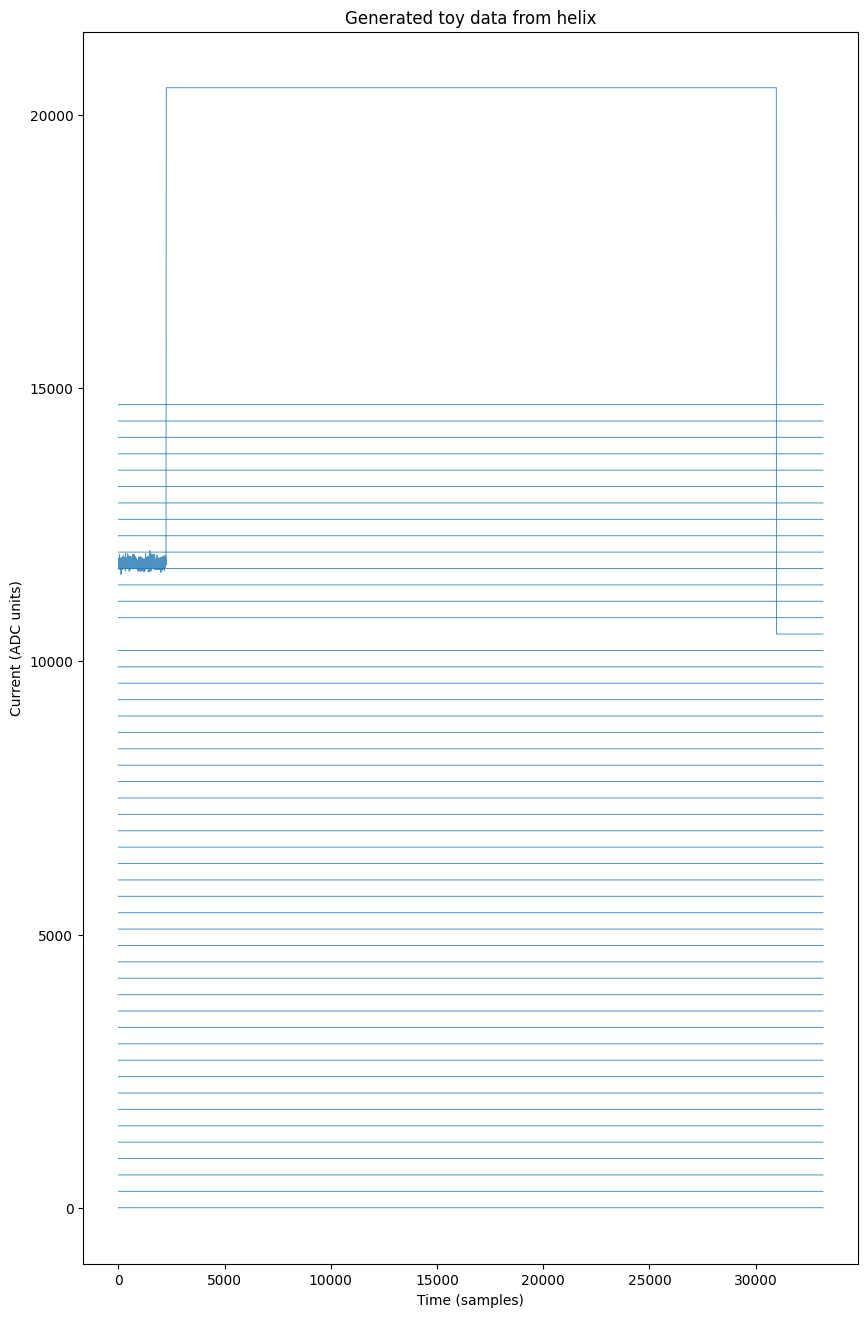

In [9]:
run_id = 'run10' 
raw_data_dir = 'toy_data'  # to save the raw toy data
helix_data_dir = 'test_helix_data'  # to save the run metadata
# creating context, registering storage and plugins
context = sx.Context(storage=[sx.DataDirectory(helix_data_dir, provide_run_metadata=True), ],
                     register=[hx.MMCRecords,
                               hx.QPTriggers, hx.UVTriggers,
                               hx.Events, hx.NoiseEvents,
                               hx.NoisePSDs, hx.FitResults])    # all the plugins required for getting fit_results

# creating a dictionary of plugins' options that we want to modify. 
config = {'run_metadata_directory': helix_data_dir,      # for the hx.ToyDataRawRecords plugin
          'noise_events_random_seed': 1}                 # for the hx.NoiseEvents plugin

# passing the settings to the plugins. Strax finds which plugins take these options automatically
context.set_config(config)
events = context.get_array(run_id, 'events')

# Load the raw data directly from the events or traces
raw_data = events['channel_data']

# Choose the event to plot
event_index = 16  # Change this index to select a different event

# Generate artificial baselines to separate channels visually
artificial_baselines = np.arange(len(raw_data[event_index])) * 300

# Plot the raw data
plt.figure(figsize=(10, 16))
plt.plot(raw_data[event_index].T + artificial_baselines, lw=0.7, alpha=0.8, color='C0')
plt.xlabel('Time (samples)')
plt.ylabel('Current (ADC units)')
plt.title(f'Generated toy data from helix')
#plt.savefig('raw_data_traces_plot.png', dpi=300, bbox_inches='tight')

plt.show()


In [10]:
fit_results = context.get_array(run_id, 'fit_results')  # hx.FitResults plugin provides this data type


Exception during processing, closing savers and reraising     | 0.00 % [00:00<?]
Loading fit_results: |                                        | 0.00 % [00:00<?]


ValueError: need at least one array to concatenate